In [3]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.rdf import *
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.analysis.base import AnalysisFromFunction
import matplotlib.pyplot as plt
import os,re
import fnmatch
import dask
import dask.array as da
import pickle

In [3]:
def find_and_list_files(searchstring:str):

	filelist = []
	
	for file in os.listdir('.'):
		if fnmatch.fnmatch(file, str(searchstring)):
			filelist.append(file)
			
	filelist.sort()
	
	return filelist

In [ ]:
# list topologies in directory

grofiles = find_and_list_files('*.gro')
tprs = find_and_list_files('*.tpr')

### fix broken molecules and center protein ###

In [ ]:
# apply pbc

for filenumber, filename in enumerate(grofiles):
	os.system('echo 0 | gmx_mpi trjconv -f '+str(filename[:-4])+'.xtc -pbc mol -ur rect -boxcenter rect -s '+str(tprs[filenumber])+' -o '+str(filename[:-4])+'pbc.xtc')

In [ ]:
trajectories = find_and_list_files('*pbc.xtc')

In [ ]:
# center protein

for trajectorynumber, trajectoryname in enumerate(trajectories):
	os.system('echo 1 0 | gmx_mpi trjconv -f '+str(trajectoryname)+' -s '+str(tprs[trajectorynumber])+' -center -pbc mol -ur rect -o '+str(trajectoryname[:-4])+'-c.xtc')

In [ ]:
trajectories_centered = find_and_list_files('*pbc-c.xtc')

### calculate reaction coordinate zeta ###

In [ ]:
#calculate center of mass for groups 51 (membrane) and 52 (CAcys191)
for i,coord in enumerate(trajectories_centered):
	os.system('echo 51 52 | gmx_mpi traj -f '+str(coord)+' -s '+str(tprs[i])+' -ox '+str(coord[:-9])+'.xvg -com -nox -noy -ng 2 -n index.ndx') # COM z-dist and CALys z-dist

In [ ]:
#calculate distance btwn membrane com and cacys191 com for all sims in folder
zeta = []
for i,sim_file in enumerate(trajectories_centered):
	read = []
	f = open(str(sim_file[:-9])+'.xvg', 'r')
	for line in f.readlines():
		line = line.strip()
		read.append(line)
	f.close()
	header = [line_no for line_no,line in enumerate(read) if '@' in line]
	header_end = header[-1]+1
	read = []
	
	zdata = np.genfromtxt(str(sim_file[:-9])+'.xvg', skip_header = header_end)
	membrane_com_z = np.mean(zdata[:,1])
	c_alpha_cys191_z = np.mean(zdata[:,2])
	z_distance = c_alpha_cys191_z - membrane_com_z
	zeta.append(z_distance)

In [ ]:
#collect dists in one file
output_data = np.rec.fromarrays((trajectories_centered, zeta))
np.savetxt('zeta.txt', output_data, header='traj dist COM(m)_CAcys191 / nm',delimiter=' ',fmt=['%s','%.5f']) #dist COM-CALys in z dir

### PO4 & water analysis ###

In [ ]:
def extract_coords_traj(atomselection):
    coords = da.from_array(AnalysisFromFunction(lambda ag: ag.positions.copy(), atomselection.atoms).run().results['timeseries'])
    return coords   

In [48]:
def calc_distance_1d(xyz_index, frame, center_of_geom):

    distance = frame[:,xyz_index] - center_of_geom #create vectors for x,y,z
    return distance

In [46]:
def create_vectormask(coordframe_protein, coordframe_mol):

    xyz_index = 0
    while xyz_index < 3:
        center_of_geom = da.sum(coordframe_protein[:,xyz_index] / coordframe_protein[:,xyz_index].size) # center of geometry of lower beta hairpins
        if xyz_index == 0:
            xdist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom) # vectors h2o/po4 -> cog for x coord
        elif xyz_index == 1:
            ydist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom)
        elif xyz_index == 2:
            zdist = calc_distance_1d(xyz_index, coordframe_mol, center_of_geom)
        xyz_index += 1

    vecmask = da.vstack((xdist, ydist, zdist)) 
    return vecmask

In [44]:
class pore_analyzer:
    
    def __init__(self):
        
        self.trajectory_list = []
        self.topology_list = []
         
        # atom groups storage dict
        self.ag_storage = {"h2o":{'selection_str':'resname SOL and name OW',
                                     'ag':[],
                                 'coords':[],
                                 'resnums':[]},
                          "po4":{'selection_str':'not (resname SOL or resname NA or resname CL) and not protein and name OP*',
                                     'ag':[],
                                 'coords':[],
                                'resnums':[]},
                          "lipids":{'selection_str':'not (resname SOL or resname NA or resname CL) and not protein',
                                         'ag':[],
                                    'coords':[]},
                          "protein":{'selection_str':'protein and (resid 86-114 or resid 174-203)',# gasdermin-D, for gasdermin-A3 use resid 83-109 or resid 167-195
                                         'ag':[],
                                     'coords':[]}
                          }

        # lists to collect avgs in defects (or the exact numbers in the 1-frame case)
        self.in_defect_avg = {'h2o':[],
                              'po4':[]}
        
    def get_atom_groups_coords(self, sourcedata):
        
        u = mda.Universe(*sourcedata)

        for atomgroup in self.ag_storage:
            self.ag_storage[atomgroup]['ag'] = u.select_atoms(self.ag_storage[atomgroup]['selection_str'])
            if len(sourcedata) > 1:
                self.ag_storage[atomgroup]['coords'] = extract_coords_traj(self.ag_storage[atomgroup]['ag'])
            else:
                self.ag_storage[atomgroup]['coords'] = da.from_array(self.ag_storage[atomgroup]['ag'].positions.copy())
            
                
    def calc_membrane_dimensions(self, lipid_z_coords, phosphate_z_coords):    
        
        self.membrane_middle = da.mean(lipid_z_coords)
        self.membrane_zmax = da.mean(phosphate_z_coords[(phosphate_z_coords > self.membrane_middle)]) + 2 # +/- 2 angström buffer for a little unevenness of membrane
        self.membrane_zmin = da.mean(phosphate_z_coords[(phosphate_z_coords < self.membrane_middle)]) - 2
                                     
    def filter_coords_traj(self, ag):
        
        self.z_mask = (self.vectormasks[ag][:,:,2] > -30) & (self.vectormasks[ag][:,:,2] < +30).compute() # filter for z coord in 30 A dist from center of geom
        self.radii = (self.vectormasks[ag][:,:,0]**2 + self.vectormasks[ag][:,:,1]**2).compute() # radial filter based on x and y coord (around 10 A radius)
        self.xy_mask = ((da.from_array(self.radii) < 10**2)).compute()
                                     
    def filter_coords_singleframe(self, ag):
    
        self.z_mask = (self.vectormasks[ag][:,2] > -30) & (self.vectormasks[ag][:,2] < +30).compute() # filter for z coord in 30 A dist from center of geom
        self.radii = (self.vectormasks[ag][:,0]**2 + self.vectormasks[ag][:,1]**2).compute() # radial filter based on x and y coord (around 10 A radius)
        self.xy_mask = ((da.from_array(self.radii) < 10**2)).compute()       
                                     
    def id_molecules_traj(self, atomgroup, ag, coords_in_membrane_mask):
        
        residue_numbers = (da.atleast_2d(atomgroup.resnums).T).compute()
        z_mask_resnums = da.hstack((residue_numbers, (self.z_mask.T).compute()))
        xy_mask_resnums = da.hstack((residue_numbers, (da.from_array(self.xy_mask).T).compute()))
        resnums_in_membr = da.hstack((residue_numbers, (coords_in_membrane_mask.T).compute()))
                                     
        # compare mask id resnums 
        xyz_resnums = da.add(xy_mask_resnums[:,1:], z_mask_resnums[:,1:])
        all_resnums = da.add(xyz_resnums, resnums_in_membr[:,1:])
	
        comp = (all_resnums == 3).compute() # only consider resnums that appear in all 3 filters
        id_resnums = da.hstack((residue_numbers, comp))
	
        no_of_defect_molecules = da.sum(id_resnums[:,1:], axis=0) # count for each frame
        traj_average = da.mean(no_of_defect_molecules)
        self.in_defect_avg[ag].append(traj_average)
                                     
        xyz_resnums = []
        all_resnums = []
                                     
        return no_of_defect_molecules
    
    def id_molecules_single(self, atomgroup, ag, coords_in_membrane_mask):
        
        residue_numbers = (atomgroup.resnums)
        z_mask_resnums = np.vstack((residue_numbers, (self.z_mask))).T
        xy_mask_resnums = np.vstack((residue_numbers, (self.xy_mask))).T
        resnums_in_membr = np.vstack((residue_numbers, (coords_in_membrane_mask))).T
                                     
        # compare mask id resnums 
        xyz_resnums = np.add(xy_mask_resnums, z_mask_resnums)  
        all_resnums = np.add(xyz_resnums, resnums_in_membr)
           
        comp = (all_resnums[:,1] == 3) # only consider resnums that appear in all 3 filters
        id_resnums = np.array(np.vstack((residue_numbers, comp)).T)
        
        no_of_defect_molecules = np.sum(comp) # count
        self.in_defect_avg[ag].append(no_of_defect_molecules) # in this case it's not an avg ;-)
        
        # find the resnums and store them
        self.id_resnums = []
        for resnum, found in enumerate(id_resnums[:,1]):
            if found != 0:
                self.id_resnums.append(id_resnums[:,0][resnum])
	                            
        xyz_resnums = []
        all_resnums = []
                                     
        return no_of_defect_molecules
    
    ###### backend #######
    
    def export_data_loop(self, ag_name, traj_number, traj, no_of_defect_molecules):

        data=np.stack((self.trajectory_list[:traj_number+1], self.in_defect_avg[ag_name]),axis=1)
        np.savetxt('no_of_'+str(ag_name)+'_avg_per_traj.txt', data, fmt=['%s', '%.5f'], delimiter=' ', newline='\n', header='traj '+str(ag_name)+'_in_defect')
                                     
    def export_final_data_single(self, ag, no_of_defect_molecules):

        np.savetxt('no_of_'+str(ag)+'_single.txt',no_of_defect_molecules,fmt='%s',delimiter=' ',newline='\n',header=str(ag)+'_in_defect')
                                     
    def export_final_data_pdb(self, ag, no_of_defect_molecules): 
        
        np.savetxt('resnums_'+str(ag)+'_in_def_'+str(self.pdbfile[:-4])+'.txt', self.ag_storage[ag]['resnums'], delimiter=' ', fmt='%i',newline='\n',header=str(no_of_defect_molecules)+' '+str(ag)+' in defect')                            
                                     
    ###### production ######

    def looprun(self):
        
        for traj_number, traj in enumerate(self.trajectory_list):
            
            if traj_number > 44:
            
                self.get_atom_groups_coords([self.topology_list[traj_number], traj])

                # find coords in pore 
                self.vectormasks = {'h2o':[],
                                    'po4':[]}
                self.coords_in_membrane_masks = {'h2o':[],
                                           'po4':[]}


                for frame_no, frame in enumerate(self.ag_storage['protein']['coords']):

                    # membrane dimensions
                    lipid_z_coords = self.ag_storage['lipids']['coords'][:,:,2][frame_no]
                    phosphate_z_coords = self.ag_storage['po4']['coords'][:,:,2][frame_no]

                    self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)


                    for ag_n, ag in enumerate(['h2o', 'po4']):

                        vecmask = create_vectormask(frame, self.ag_storage[ag]['coords'][frame_no])

                        # find h2o/po4 in membrane region adaptive to conditions in each frame    
                        ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,:,2][frame_no] < self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,:,2][frame_no] > self.membrane_zmin)).compute()    

                        if frame_no == 0:
                            self.vectormasks[ag] = (vecmask.T).compute()
                            self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask

                        elif frame_no == 1:
                            self.vectormasks[ag] = da.stack((self.vectormasks[ag],(vecmask.T).compute()))
                            self.coords_in_membrane_masks[ag] = da.stack((self.coords_in_membrane_masks[ag], ag_coords_in_membrane_mask))

                        else: 
                            self.vectormasks[ag] = da.append(self.vectormasks[ag], (da.atleast_3d(vecmask).T).compute(), axis = 0)
                            self.coords_in_membrane_masks[ag] = da.append(self.coords_in_membrane_masks[ag], da.array([ag_coords_in_membrane_mask]), axis = 0)               

                for ag_n, ag in enumerate(['h2o', 'po4']):

                    self.filter_coords_traj(ag)

                    no_of_defect_molecules = self.id_molecules_traj(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag])

                    self.export_data_loop(ag, traj_number, traj, no_of_defect_molecules)
                                     
                
            
    def singletrajrun(self, topology, trajectory):
                                     
        self.get_atom_groups_coords([topology, trajectory])
        
        # find coords in pore 
        self.vectormasks = {'h2o':[],
                            'po4':[]}
        self.coords_in_membrane_masks = {'h2o':[],
                                   'po4':[]}
                                     
        for frame_no, frame in enumerate(self.ag_storage['protein']['coords']):

            # membrane dimensions
            lipid_z_coords = self.ag_storage['lipids']['coords'][:,:,2][frame_no]
            phosphate_z_coords = self.ag_storage['po4']['coords'][:,:,2][frame_no]

            self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)

            for ag_n, ag in enumerate(['h2o', 'po4']):

                vecmask = create_vectormask(frame, self.ag_storage[ag]['coords'][frame_no])
                
                # find h2o/po4 in membrane region adaptive to conditions in each frame    
                ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,:,2][frame_no] < self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,:,2][frame_no] > self.membrane_zmin)).compute()    

                if frame_no == 0:
                    self.vectormasks[ag] = (vecmask.T).compute()
                    self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask

                elif frame_no == 1:
                    self.vectormasks[ag] = da.stack((self.vectormasks[ag],(vecmask.T).compute()))
                    self.coords_in_membrane_masks[ag] = da.stack((self.coords_in_membrane_masks[ag], ag_coords_in_membrane_mask))

                else: 
                    self.vectormasks[ag] = da.append(self.vectormasks[ag], (da.atleast_3d(vecmask).T).compute(), axis = 0)
                    self.coords_in_membrane_masks[ag] = da.append(self.coords_in_membrane_masks[ag], da.array([ag_coords_in_membrane_mask]), axis = 0)             

        for ag_n, ag in enumerate(['h2o', 'po4']):
            
            self.filter_coords_traj(ag)

            no_of_defect_molecules = self.id_molecules_traj(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag])

            self.export_final_data_single(ag, no_of_defect_molecules)
                                     
                                     
            
    def singleframerun(self, pdbfile:str):
        
        self.get_atom_groups_coords([pdbfile])
        
        # membrane dims
        lipid_z_coords = self.ag_storage['lipids']['coords'][:,2]
        phosphate_z_coords = self.ag_storage['po4']['coords'][:,2]

        self.calc_membrane_dimensions(lipid_z_coords,phosphate_z_coords)

        # find coords in pore
        self.vectormasks = {'h2o':[],
                            'po4':[]}  
        self.coords_in_membrane_masks = {'h2o':[],
                                   'po4':[]}
        
        for ag_n, ag in enumerate(['h2o', 'po4']):
            
            vecmask = create_vectormask(self.ag_storage['protein']['coords'], self.ag_storage[ag]['coords'])
                                                                                                                                
           # find h2o/po4 in membrane region adaptive to conditions in each frame    
            ag_coords_in_membrane_mask = ((self.ag_storage[ag]['coords'][:,2]<self.membrane_zmax) & (self.ag_storage[ag]['coords'][:,2] > self.membrane_zmin)).compute()  
            self.coords_in_membrane_masks[ag] = ag_coords_in_membrane_mask
        
            self.vectormasks[ag] = vecmask.T        

            self.filter_coords_singleframe(ag)

            no_of_defect_molecules = np.array(self.id_molecules_single(self.ag_storage[ag]['ag'], ag, self.coords_in_membrane_masks[ag]))
            print(no_of_defect_molecules)
            self.ag_storage[ag]['resnums'] = self.id_resnums
            self.export_final_data_pdb(ag, no_of_defect_molecules)

#### multiple trajs ####

In [15]:
Pore_analyzer = pore_analyzer()

In [16]:
Pore_analyzer.trajectory_list = trajectories_centered
Pore_analyzer.topology_list = tprs

In [ ]:
Pore_analyzer.looprun()

#### single traj ####

In [ ]:
top = 'umbrella_1-3mus_0.gro' 
traj = 'umbrella_1-3mus_0pbc-c.xtc'

Pore_analyzer = pore_analyzer()

Pore_analyzer.singletrajrun(top, traj)

#### single pdb ####

In [ ]:
pdbfile = 'umbrella_ads_23_frame5000.pdb'

Pore_analyzer = pore_analyzer()

Pore_analyzer.singleframerun(pdbfile)

In [ ]:
####### use this to get a pdb with only the protein, membrane and the water molecules in the defect ########

u0=mda.Universe(pdbfile)
water_resnums = (np.genfromtxt('resnums_h2o_in_def_'+frame[:-4]+'.txt', dtype=int)).tolist()

atomlist = []
for resnum in water_resnums:

    ag = u0.select_atoms('resnum '+str(resnum))
    for atomindex in ag.ix:
        atomlist.append(atomindex)

waters = u0.atoms[atomlist]
rest = u0.select_atoms('protein or not (resname SOL or resname CL or resname NA)')
combined = mda.Merge(rest, waters)
combined.atoms.write('porewateronly_'+frame[:-4]+'.pdb')

### calculate possible salt bridge distances ###

In [4]:
############################# salt bridge dist gasdermin D ################################################

from MDAnalysis.analysis import distances

def calculate_distance(atomselection1, atomselection2):
	
	resid1, resid2, distance = distances.dist(atomselection1, atomselection2)
	
	return distance
	
def select_atoms_sb(resid,atomname,u):

	atomgroup = u.select_atoms('resid '+str(resid)+' and name '+str(atomname))

	return atomgroup

In [9]:
#store data for all trajs gasdermin D specific
dist_saltbridges={'R183E195':[['ARG',183,'CZ'],
							  ['GLU',195,'CD'],
							  []],
				  'K177E179':[['LYS',177,'NZ'],
				  			  ['GLU',179,'CD'],
							  []],
				  'R178D112':[['ARG',178,'CZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'R174D112':[['ARG',174,'CZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'K177D112':[['LYS',177,'NZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'K177D87':[['LYS', 177, 'NZ'],
							 ['ASP', 87, 'CG'],
							 []],                 
				  'K103E95':[['LYS',103,'NZ'],
				  			 ['GLU',95,'CD'],
							 []],
				  'R183E179':[['ARG',183,'CZ'],
				  			  ['GLU',179,'CD'],
							  []],
				  'K203E179':[['LYS',203,'NZ'],
				  			  ['GLU',179,'CD'],
							  []],
				   'R174D87' :[['ARG',174,'CZ'],
							   ['ASP',87,'CG'],
						 	   []],
				   'R178E195':[['ARG',178,'CZ'],
				   			   ['GLU',195,'CD'],
					 		   []],
				   'R178E179':[['ARG',178,'CZ'],
				  			   ['GLU',179,'CD'],
							   []],
				   'R183E195':[['ARG',183,'CZ'],
				  			   ['GLU',195,'CD'],
							   []],
				   'K103E195':[['LYS',103,'NZ'],
				  			   ['GLU',195,'CD'],
							   []],
				   'K203D87':[['LYS', 203, 'NZ'],
							  ['ASP', 87, 'CG'],
							  []],
				   'K203D112':[['LYS',203,'NZ'],
				  			   ['ASP',112,'CG'],
							   []],
				   'K204D112':[['LYS',204,'NZ'],
				  			   ['ASP',112,'CG'],
							   []],
				   'K204D87': [['LYS',204,'NZ'],
				  			   ['ASP',87,'CG'],
							   []],
				   'R183E95':[['ARG',183,'CZ'],
				  			   ['GLU',95,'CD'],
							   []],
							   }

## salt bridge occurence ##

In [12]:
#store data for all trajs gasdermin D specific
occ_saltbridges={'R183E195':[['ARG',183,'CZ'],
							  ['GLU',195,'CD'],
							  []],
				  'K177E179':[['LYS',177,'NZ'],
				  			  ['GLU',179,'CD'],
							  []],
				  'R178D112':[['ARG',178,'CZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'R174D112':[['ARG',174,'CZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'K177D112':[['LYS',177,'NZ'],
				  			  ['ASP',112,'CG'],
							  []],
				  'K177D87':[['LYS', 177, 'NZ'],
							 ['ASP', 87, 'CG'],
							 []],                 
				  'K103E95':[['LYS',103,'NZ'],
				  			 ['GLU',95,'CD'],
							 []],
				  'R183E179':[['ARG',183,'CZ'],
				  			  ['GLU',179,'CD'],
							  []],
				  'K203E179':[['LYS',203,'NZ'],
				  			  ['GLU',179,'CD'],
							  []],
                   'R174D87' :[['ARG',174,'CZ'],
							   ['ASP',87,'CG'],
						 	   []],
				   'R178E195':[['ARG',178,'CZ'],
				   			   ['GLU',195,'CD'],
					 		   []],
				   'R178E179':[['ARG',178,'CZ'],
				  			   ['GLU',179,'CD'],
							   []],
				   'R183E195':[['ARG',183,'CZ'],
				  			   ['GLU',195,'CD'],
							   []],
				   'K103E195':[['LYS',103,'NZ'],
				  			   ['GLU',195,'CD'],
							   []],
				   'K203D87':[['LYS', 203, 'NZ'],
							  ['ASP', 87, 'CG'],
							  []],
				   'K203D112':[['LYS',203,'NZ'],
				  			   ['ASP',112,'CG'],
							   []],
				   'K204D112':[['LYS',204,'NZ'],
				  			   ['ASP',112,'CG'],
							   []],
                   'K204D87': [['LYS',204,'NZ'],
                               ['ASP',87,'CG'],
                               []],
                   'R183E95':[['ARG',183,'CZ'],
				  			   ['GLU',95,'CD'],
							   []],
							   }

In [ ]:
#loop over trajs
for filenumber, filename in enumerate(trajectories_centered): # use only traj files to loop over due to possible sorting errors

    u = mda.Universe(filename[:-9]+'.gro', filename)

    for saltbridge in dist_saltbridges.keys():

        atomgroup1 = select_atoms_sb(dist_saltbridges[saltbridge][0][1], dist_saltbridges[saltbridge][0][2], u)
        atomgroup2 = select_atoms_sb(dist_saltbridges[saltbridge][1][1], dist_saltbridges[saltbridge][1][2], u)

        #loop over 1 traj
        distances = []

        for ts in u.trajectory:

            distance = calculate_distance(atomgroup1, atomgroup2)

            distances.append(distance)

        distances = np.array(distances)

        dist_saltbridges[saltbridge][-1].append(np.mean(distances))
        with open('dist_saltbridges_d.pkl', 'wb') as f:
            pickle.dump(dist_saltbridges, f)

        # already filters by salt bridge limit :)
        if (dist_saltbridges[saltbridge][0][0] == 'ARG' and dist_saltbridges[saltbridge][1][0] == 'GLU') == True:
            occurence = len(np.argwhere(distances <= 5.28)) / len(distances)
        elif (occ_saltbridges[saltbridge][0][0] == 'LYS' and dist_saltbridges[saltbridge][1][0] == 'GLU') == True:
            occurence = len(np.argwhere(distances <= 4.58)) / len(distances)
        elif (dist_saltbridges[saltbridge][0][0] == 'LYS' and dist_saltbridges[saltbridge][1][0] == 'ASP') == True:
            occurence = len(np.argwhere(distances <= 4.40)) / len(distances)
        elif (dist_saltbridges[saltbridge][0][0] == 'ARG' and dist_saltbridges[saltbridge][1][0] == 'ASP') == True:
            occurence = len(np.argwhere(distances <= 5.1)) / len(distances)
        occ_saltbridges[saltbridge][-1].append(occurence)

        with open('occ_saltbridges_d.pkl', 'wb') as f2:
            pickle.dump(occ_saltbridges, f2)

In [ ]:
f.close()
f2.close()

In [13]:
# read in if necessary
with open('dist_saltbridges_d.pkl', 'rb') as f:
    dist_saltbridges = pickle.load(f)

In [4]:
# read in if necessary
with open('occ_saltbridges_d.pkl', 'rb') as f:
    occ_saltbridges = pickle.load(f)

In [5]:
f.close()

In [16]:
dist_saltbridges.keys()

dict_keys(['R183E195', 'K177E179', 'R178D112', 'R174D112', 'K177D112', 'K177D87', 'K103E95', 'R183E179', 'K203E179', 'R174D87', 'R178E195', 'R178E179', 'K103E195', 'K203D87', 'K203D112', 'K204D112', 'K204D197', 'K204D87', 'R183E95'])

In [6]:
occ_saltbridges.keys()

dict_keys(['R183E195', 'K177E179', 'R178D112', 'R174D112', 'K177D112', 'K177D87', 'K103E95', 'R183E179', 'K203E179', 'R174D87', 'R178E195', 'R178E179', 'K103E195', 'K203D87', 'K203D112', 'K204D112', 'K204D87', 'R183E95'])

In [7]:
ordered_saltbridges=['K103E95', 'K103E195','R183E95','R183E195','R174D112','K177D87','K177E179']

In [8]:
# Custom order dictionary
ordered_sb_dict = dict()
for sb in ordered_saltbridges:
    ordered_sb_dict[sb] = occ_saltbridges[sb]

In [9]:
ordered_sb_dict.keys()

dict_keys(['K103E95', 'K103E195', 'R183E95', 'R183E195', 'R174D112', 'K177D87', 'K177E179'])

#### sort saltbridges by insertion depth (zeta) ####

In [14]:
# sort by insertion depth
zeta = np.genfromtxt('zeta.txt', usecols = 1, dtype = float, delimiter = ' ')

In [15]:
def sort_by_zeta(zeta, ordered_dictionary:dict, dictionary:dict):
    
    for key_no, key in enumerate(ordered_dictionary.keys()):
        if key_no == 0:
            sorted_dict = np.column_stack((zeta, np.array(dictionary[key][2])))
        if key_no > 0:
            sorted_dict = np.hstack((sorted_dict, np.atleast_2d(dictionary[key][2]).T))
    sorted_dict = sorted_dict[sorted_dict[:,0].argsort()]
    
    return sorted_dict

In [23]:
sorted_saltbridges = sort_by_zeta(zeta, ordered_sb_dict, dist_saltbridges)

In [33]:
np.savetxt('sorted_dist_saltbridges_d.txt', sorted_saltbridges, delimiter=' ', newline='\n', fmt='%f', header='zeta / nm distance(R183E195, K177E179, R178D112, R174D112, K177D112, K177D87, K103E95, R183E179, K203E179, R174D87, R178E195, R178E179, R183E195, K103E195, K203D87, K203D112, K204D112, K204D197, K204D87) / A')

In [16]:
sorted_occ = sort_by_zeta(zeta, ordered_sb_dict, occ_saltbridges)

In [33]:
np.savetxt('sorted_occ_saltbridges_d.txt', sorted_occ, delimiter=' ', newline='\n', fmt='%f', header='zeta / nm occurrence(R183E195, K177E179, R178D112, R174D112, K177D112, K177D87, K103E95, R183E179, K203E179, R174D87, R178E195, R178E179, R183E195, K103E195, K203D87, K203D112, K204D112, K204D197, K204D87)')

#### sort simulation files by zeta  ####

In [27]:
simlist = np.genfromtxt('zeta.txt', usecols = 0, delimiter = ' ', dtype = str) # correct order

In [28]:
simlist = np.column_stack((zeta, simlist))

In [29]:
defined_simlist = np.rec.fromrecords(simlist, dtype=[('zeta', 'float64'), ('simlist', '<U64')])

/tmp/ipykernel_204878/1062704682.py:1: FutureWarning: fromrecords expected a list of tuples, may have received a list of lists instead. In the future that will raise an error
  defined_simlist = np.rec.fromrecords(simlist, dtype=[('depth', 'float64'), ('simlist', '<U64')])


In [31]:
sorted_simlist = defined_simlist[defined_simlist.zeta.argsort()]

In [ ]:
np.savetxt('sorted_simlist.txt', sorted_simlist, fmt='%s', header='zeta / nm simulation_name')

### plot saltbridge occurrence ###

In [10]:
####### plot settings #####
plt.rcParams["figure.figsize"] = (16.5,11)
plt.rcParams["font.size"] = 24

In [11]:
color_list=['#addc30','#3b528b','#28ae80','#440154','#5ec962','#21918c', '#472d7b']

In [12]:
marker_list=['-','--','-.',':',(0, (3, 1, 3, 1, 3, 1)),(0, (3, 1, 1, 1, 1, 1)),(0, (3, 1, 3, 1, 1, 1)),(0, (1, 1, 1, 1, 1, 1,4))]

sb_nr: 3 R183E95
sb_nr: 3 R183E195
sb_nr: 4 R174D112
sb_nr: 6 K177D87
sb_nr: 6 K177E179


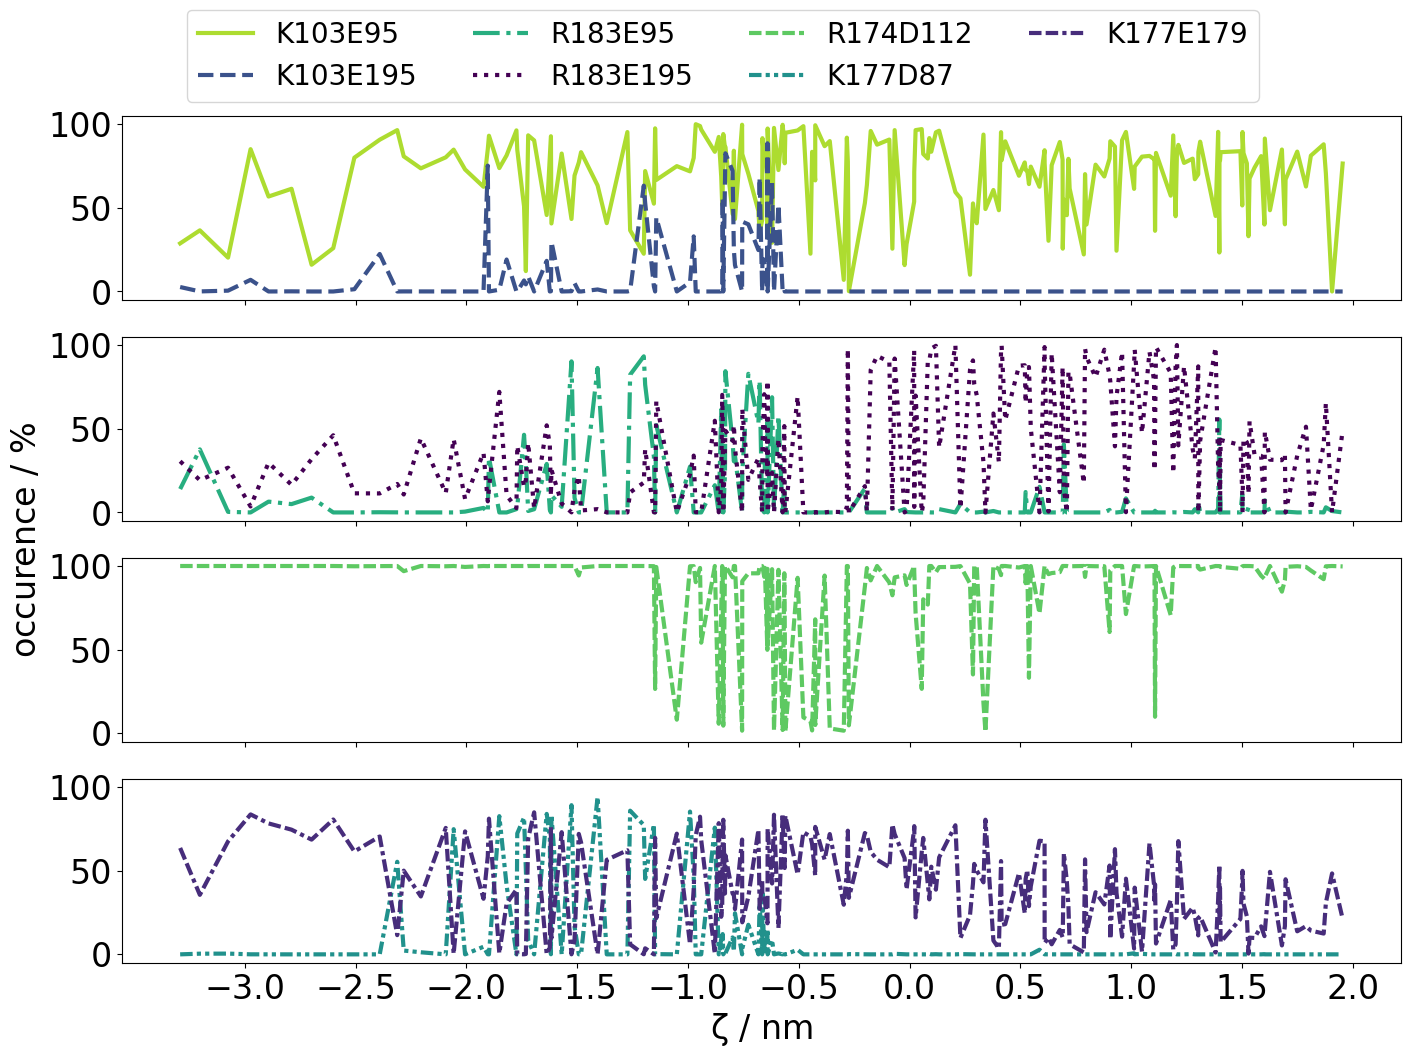

In [17]:
for sb_nr,saltbridge in enumerate(ordered_sb_dict.keys()):
    if sb_nr < 2:
        ax1 = plt.subplot(411)
        plt.plot(sorted_occ[:,0][:201],(sorted_occ[:,(sb_nr+1)][:201])*100,label=saltbridge, color=color_list[sb_nr], linewidth=3, linestyle=marker_list[sb_nr])
        plt.xticks(np.arange(-3.0,3.0,0.5))
        plt.yticks(np.arange(0,150,50))
        plt.tick_params('x', labelbottom=False)
        all_handles, all_labels = plt.gca().get_legend_handles_labels()
        #plt.legend()
    elif (sb_nr > 1 and sb_nr < 4) == True:
        ax2 = plt.subplot(412, sharey=ax1, sharex=ax1)
        plt.plot(sorted_occ[:,0][:201],(sorted_occ[:,(sb_nr+1)][:201])*100,label=saltbridge, color=color_list[sb_nr], linewidth=3, linestyle=marker_list[sb_nr])
        plt.tick_params('x', labelbottom=False)
        
        if sb_nr == 3:
            handles, labels = plt.gca().get_legend_handles_labels()
            for handle in handles:
                all_handles.append(handle)
            for label in labels:
                print('sb_nr: '+str(sb_nr)+' '+label)
                all_labels.append(label)

    elif (sb_nr > 3 and sb_nr < 5) == True:
        ax3 = plt.subplot(413, sharey=ax1, sharex=ax1)
        plt.plot(sorted_occ[:,0][:201],(sorted_occ[:,(sb_nr+1)][:201])*100,label=saltbridge, color=color_list[sb_nr], linewidth=3, linestyle=marker_list[sb_nr])
        plt.tick_params('x', labelbottom=False)
        
        if sb_nr == 4:
            handles, labels = plt.gca().get_legend_handles_labels()
            for handle in handles:
                all_handles.append(handle)
            for label in labels:
                print('sb_nr: '+str(sb_nr)+' '+label)
                all_labels.append(label)
                
    elif sb_nr > 4:
        ax4 = plt.subplot(414, sharey=ax1, sharex=ax1)
        plt.plot(sorted_occ[:,0][:201],(sorted_occ[:,(sb_nr+1)][:201])*100,label=saltbridge, color=color_list[sb_nr], linewidth=3, linestyle=marker_list[sb_nr])

        if sb_nr == 6:
            handles, labels = plt.gca().get_legend_handles_labels()
            for handle in handles:
                all_handles.append(handle)
            for label in labels:
                print('sb_nr: '+str(sb_nr)+' '+label)
                all_labels.append(label)            

plt.legend(all_handles, all_labels, bbox_to_anchor=(0.9, 5.25),ncol=4, fontsize=20)
plt.ylabel(r'occurence / $\mathrm{\%}$', x=0, y=2.3)     
plt.xlabel(r'$\mathrm{\zeta}$ / nm')
plt.savefig('salt_bridge_occurence_d.png',dpi=200, transparent=True)
plt.show()
plt.close()

In [18]:
occ_avgs = []
for no, label in enumerate(all_labels):
    mean = np.mean(sorted_occ[:,no+1])
    occ_avgs.append(mean)

In [19]:
for no, label in enumerate(all_labels):
    print(label+' {:6.2f} %'.format(occ_avgs[no]*100))

K103E95  69.69 %
K103E195   5.58 %
R183E95   8.93 %
R183E195  39.69 %
R174D112  87.41 %
K177D87   7.78 %
K177E179  39.23 %
